# Introduction: Taxi Fare Prediction

Welcome to another Kaggle challenge. In this contest, the aim is to predict the fare of a taxi ride given the starting time, the starting and ending latitude / longitude, and the number of passengers. This is a __supervised regression__ machine learning task.

In this notebook, I'll provide you with a solid foundation and leave you with the challenge to better the score. Although the dataset is large, this is an approachable problem and as usual with Kaggle competitions, provides realistic practice for building a machine learning solution.

In [1]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set random seed 
RSEED = 100

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

import seaborn as sns

## Read in 5 million rows and examine data

Throughout this notebook, we will work with only 5 million rows (out of 55 million). The first point for improvement might therefore be to use more data!

* Potential improvement 1: use more data

First we'll remove any `nan` (observations with missing entries). We will also drop the `key` since it is a unique identifier and does not tell us anything about the taxi trip.

In [2]:
data = pd.read_csv('input/train.csv', nrows = 5_000_000).drop(columns = 'key')

# Remove na
data = data.dropna()
data.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.500,2009-06-15 17:26:21 UTC,-73.844,40.721,-73.842,40.712,1
1,16.900,2010-01-05 16:52:16 UTC,-74.016,40.711,-73.979,40.782,1
2,5.700,2011-08-18 00:35:00 UTC,-73.983,40.761,-73.991,40.751,2
3,7.700,2012-04-21 04:30:42 UTC,-73.987,40.733,-73.992,40.758,1
4,5.300,2010-03-09 07:51:00 UTC,-73.968,40.768,-73.957,40.784,1


### Describe Data

An effective method for catching outliers and anomalies is to find the summary statistics for the data using the `.describe()` method. I like to concentrate on the maxes and the minimums.

In [3]:
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,4999964.000,4999964.000,4999964.000,4999964.000,4999964.000,4999964.000
mean,11.341,-72.507,39.920,-72.507,39.917,1.685
std,9.820,12.810,8.963,12.848,9.487,1.332
min,-100.000,-3426.609,-3488.080,-3412.653,-3488.080,0.000
25%,6.000,-73.992,40.735,-73.991,40.734,1.000
50%,8.500,-73.982,40.753,-73.980,40.753,1.000
75%,12.500,-73.967,40.767,-73.964,40.768,2.000
max,1273.310,3439.426,3310.364,3457.622,3345.917,208.000


Right away we can see there are a number of outliers in the `latitude` and `longitude` columns as well as at least one suspicious entry in the `passenger_count`. The target varible, `fare_amount` seems to have both negative values (unexpected) and extreme values (not so unexpected).

### Examine the Target Variable

For a first graphical exploration, we can look at the distribution of the `fare_amount`, the target variable we want to train a model to predict.

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


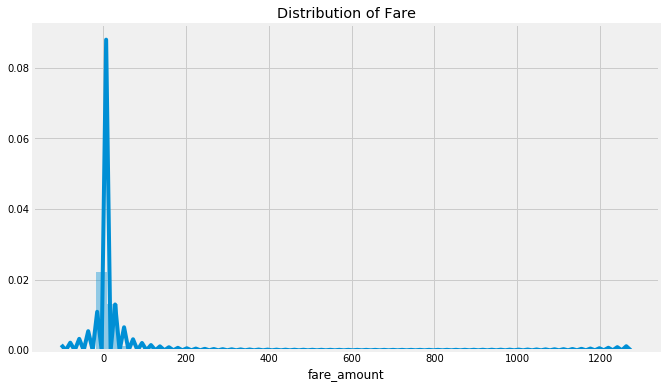

In [4]:
plt.figure(figsize = (10, 6))
sns.distplot(data['fare_amount']);
plt.title('Distribution of Fare');

In [5]:
print(f"There are {len(data[data['fare_amount'] < 0])} negative fares.")
print(f"There are {len(data[data['fare_amount'] == 0])} $0 fares.")
print(f"There are {len(data[data['fare_amount'] > 100])} fares greater than $100.")

There are 211 negative fares.
There are 132 $0 fares.
There are 1977 fares greater than $100.


### Remove Outliers

I'm going to remove any fares less than or equal to \$0 and also any fares greater than \$100. I'll justify this based on the limited number of fares outside these bounds, but it might be possible that including these values helps the model! I'd encourage you to try different values and see which works best.

In [6]:
data = data[data['fare_amount'].between(left = 0, right = 100)]

For visualization purposes, I'll create a binned version of the fare. 

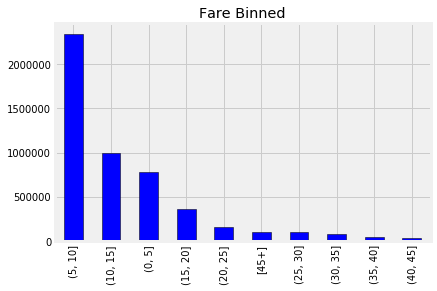

In [7]:
data['fare-bin'] = pd.cut(data['fare_amount'], bins = list(range(0, 50, 5))).astype(str)
data.loc[data['fare-bin'] == 'nan', 'fare-bin'] = '[45+]'
data['fare-bin'].value_counts().plot.bar(color = 'b', edgecolor = 'k');
plt.title('Fare Binned');

We can also remove observations based on outliers in other columns.

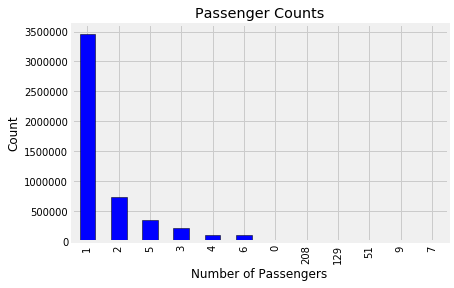

In [8]:
data['passenger_count'].value_counts().plot.bar(color = 'b', edgecolor = 'k');
plt.title('Passenger Counts'); plt.xlabel('Number of Passengers'); plt.ylabel('Count');

Based on this graph, we'll remove any passenger counts greater than 9.

In [9]:
data = data.loc[data['passenger_count'] < 10]

For the `latitude` and `longitude` columns, we can use statistics as well as our intuition for removing outliers. Here I'll find the 2.5% and 97.5% values in each column and keep only measurements close to that range. 

In [10]:
print(f'Initial Observations: {data.shape[0]}')

Initial Observations: 4997767


In [11]:
for col in ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']:
    print(f'{col.capitalize():18}: 2.5% = {round(np.percentile(data[col], 2.5), 2)} \t 97.5% = {round(np.percentile(data[col], 97.5), 2)}')

Pickup_latitude   : 2.5% = 40.64 	 97.5% = 40.8
Pickup_longitude  : 2.5% = -74.01 	 97.5% = -73.78
Dropoff_latitude  : 2.5% = 40.64 	 97.5% = 40.81
Dropoff_longitude : 2.5% = -74.01 	 97.5% = -73.78


Based on these values, we can remove outliers. Here is another potential point for improvement:

* Potential improvement 2: find a better way to remove outliers.

In [12]:
data = data.loc[(data['pickup_latitude'] > 40) & (data['pickup_latitude'] < 42)]
data = data.loc[(data['pickup_longitude'] > -75) & (data['pickup_longitude'] < -72)]
data = data.loc[(data['dropoff_latitude'] > 40) & (data['dropoff_latitude'] < 42)]
data = data.loc[(data['dropoff_longitude'] > -75) & (data['dropoff_longitude'] < -72)]

print(f'New number of observations: {data.shape[0]}')

New number of observations: 4892738


Now we can graph the `latitude` and `longitude` columns to see the distribution. We'll just sample 10000 values so the plot doesn't take too long to generate.

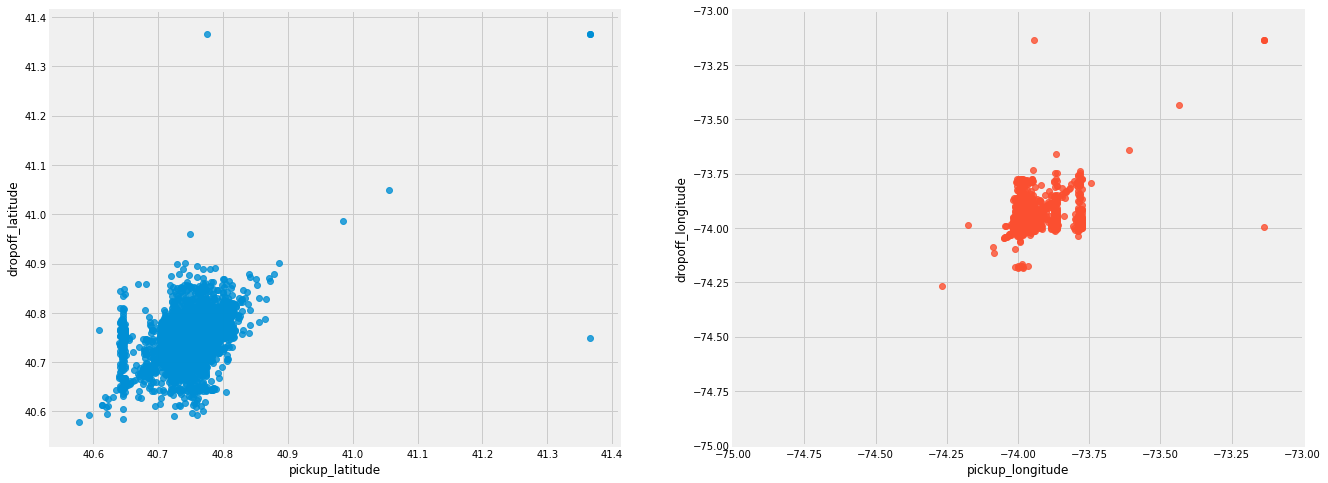

In [13]:
fig, axes = plt.subplots(1, 2, figsize = (20, 8))
axes = axes.flatten()

sns.regplot('pickup_latitude', 'dropoff_latitude', fit_reg = False, 
            data = data.sample(10000, random_state = RSEED), ax = axes[0]);
sns.regplot('pickup_longitude', 'dropoff_longitude', fit_reg = False, 
            data = data.sample(10000, random_state = RSEED), ax = axes[1]);
axes[1].set_xlim((-75, -73))
axes[1].set_ylim((-75, -73));

# Feature Engineering

As a simple first step of feature engineering, we can find the absolute value of the difference in latitude and longitude between the `pickup` and `dropoff`. While this does not represent an actual distance (we would have to convert coordinate systems), it can be used as a relative comparison of the distances of taxi rides.

In [14]:
# Absolute difference in latitude and longitude
data['abs_lat_diff'] = (data['dropoff_latitude'] - data['pickup_latitude']).abs()
data['abs_lon_diff'] = (data['dropoff_longitude'] - data['pickup_longitude']).abs()

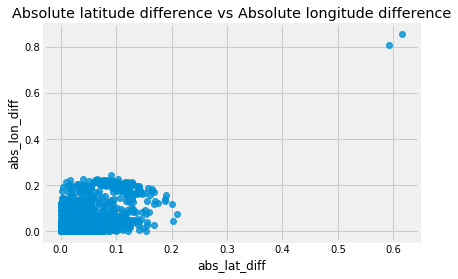

In [15]:
sns.regplot('abs_lat_diff', 'abs_lon_diff', fit_reg = False, data = data.sample(10000, random_state=RSEED));
plt.title('Absolute latitude difference vs Absolute longitude difference');

There do seem to be a few outliers, but I'll leave those in for now. We might also want to take a look if there are any observations where both the absolute differences are 0.

In [16]:
no_diff = data[(data['abs_lat_diff'] == 0) & (data['abs_lon_diff'] == 0)]
no_diff.shape

(51909, 10)

It looks like there are 52,000 rides where the absolute latitude and longitude does not change! That seems a little strange. This might be a point worth following up! 

Let's remake the plot above colored by the fare bin.

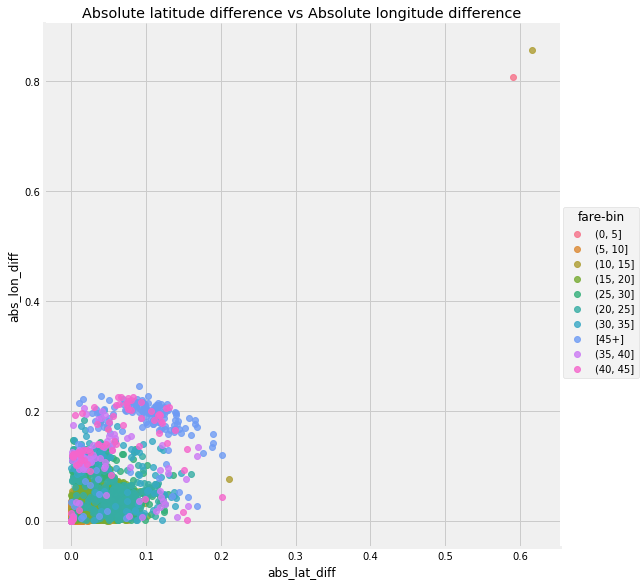

In [17]:
sns.lmplot('abs_lat_diff', 'abs_lon_diff', hue = 'fare-bin', size = 8,
           fit_reg = False, data = data.sample(10000, random_state=RSEED));
plt.title('Absolute latitude difference vs Absolute longitude difference');

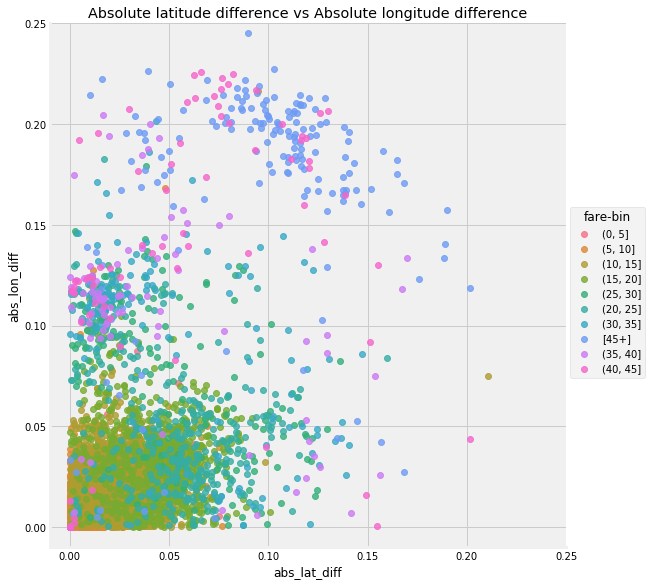

In [18]:
sns.lmplot('abs_lat_diff', 'abs_lon_diff', hue = 'fare-bin', size = 8,
           fit_reg = False, data = data.sample(10000, random_state=RSEED));

plt.xlim((-0.01, .25)); plt.ylim((-0.01, .25))
plt.title('Absolute latitude difference vs Absolute longitude difference');

Another plot we can make is the passenger count distribution colored by the fare bin.

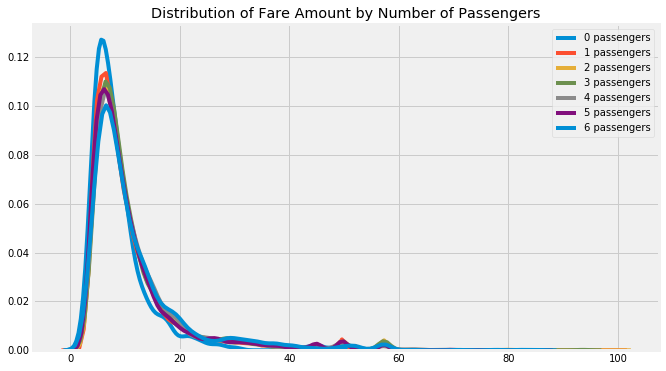

In [19]:
subset = data.sample(100000, random_state=RSEED)

plt.figure(figsize = (10, 6))

for p, grouped_data  in subset.groupby('passenger_count'):
    sns.kdeplot(grouped_data['fare_amount'], label = f'{p} passengers')
    
plt.title('Distribution of Fare Amount by Number of Passengers');

There does not appear to be much difference between the number of passengers. To get a more accurate picture, we can calculate the actual stats.

In [20]:
data.groupby('passenger_count')['fare_amount'].agg(['mean', 'count'])

,mean,count
passenger_count,,
0,8.937,17216
1,11.141,3383809
2,11.762,723437
3,11.515,214781
4,11.719,103858
5,11.187,346103
6,12.131,103532
7,8.500,1
9,37.040,1


Nope! No real difference in fare between the number of passengers.

## Read in test data and create same features

Before we forget, we need to read in the test data and create the same features. We can't exclude any of the test data based on outliers, and we also shouldn't use the test data for filtering outliers in the training data. The test data should ideally only be used a single time, to test the performance of a trained model.

For the test data, we need to save the `key` column for making submissions. 

In [21]:
test = pd.read_csv('input/test.csv')

test['abs_lat_diff'] = (test['dropoff_latitude'] - test['pickup_latitude']).abs()
test['abs_lon_diff'] = (test['dropoff_longitude'] - test['pickup_longitude']).abs()

# Save the id for submission
test_id = list(test.pop('key'))

test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_lat_diff,abs_lon_diff
count,9914.000,9914.000,9914.000,9914.000,9914.000,9914.000,9914.000
mean,-73.975,40.751,-73.974,40.752,1.671,0.022,0.023
std,0.043,0.034,0.039,0.035,1.279,0.026,0.037
min,-74.252,40.573,-74.263,40.569,1.000,0.000,0.000
25%,-73.993,40.736,-73.991,40.735,1.000,0.007,0.006
50%,-73.982,40.753,-73.980,40.754,1.000,0.015,0.013
75%,-73.968,40.767,-73.964,40.769,2.000,0.028,0.025
max,-72.987,41.710,-72.991,41.697,6.000,0.633,0.849


No fare information here! It's our job to predict the fare for each test ride.

# Calculate Distance between points using Haversine distance

Another feature engineering step to use is calculating the distance (in km) between the pickup and dropoff using the Haversine distance. This is the distance along a straight line drawn on the surface of the Earth connecting the two points. It's not the best measure because the taxis do not travel along straight lines, but it's probably more accurate than the absolute latitude and longitude difference.

In [22]:
# Radius of hte earth in kilometers
R = 6378

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    
    
    source: https://stackoverflow.com/a/29546836

    """
    # Convert latitude and longitude to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # Find the differences
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    # Apply the formula 
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    # Calculate the angle (in radians)
    c = 2 * np.arcsin(np.sqrt(a))
    # Convert to kilometers
    km = R * c
    
    return km

In [23]:
data['haversine'] =  haversine_np(data['pickup_longitude'], data['pickup_latitude'],
                         data['dropoff_longitude'], data['dropoff_latitude']) 

test['haversine'] = haversine_np(test['pickup_longitude'], test['pickup_latitude'],
                         test['dropoff_longitude'], test['dropoff_latitude'])

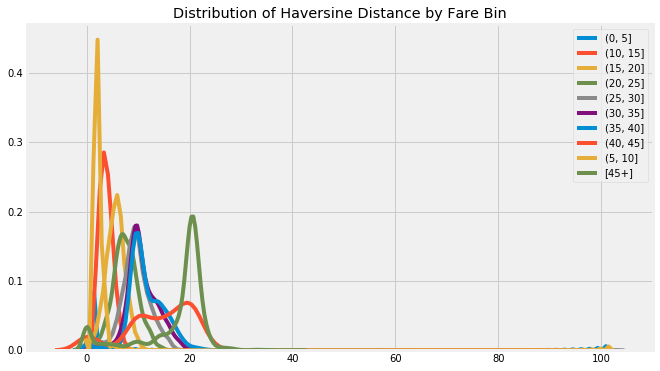

In [24]:
subset = data.sample(100000, random_state=RSEED)

plt.figure(figsize = (10, 6))

for f, grouped_data in subset.groupby('fare-bin'):
    sns.kdeplot(grouped_data['haversine'], label = f'{f}')
    
plt.title('Distribution of Haversine Distance by Fare Bin');

It does seem there is a significant difference here! The larger haversine distances tend to have larger fares as expected.

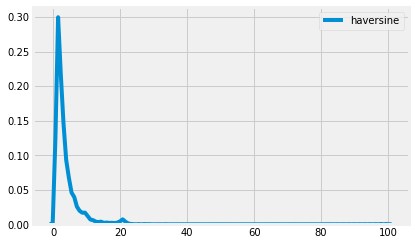

In [25]:
sns.kdeplot(test['haversine']);

# First Model

The first model we'll make is a simple linear regression using 3 features: the `abs_lat_diff`, `abs_lon_diff`, and `passenger_count`. This is meant to serve as a baseline for us to beat.

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

lr = LinearRegression()

## Create Training and Validation Set

We'll want to create a training and separate validation set to assess our model. Ideally, we only use the test set once, to evaluate the final model. We can use the validation set to estimate our performance.

In [27]:
X_train, X_valid, y_train, y_valid = train_test_split(data, np.array(data['fare_amount']), 
                                                      random_state = 40, test_size = 1_000_000)

### Use Simple Features

In [28]:
lr.fit(X_train[['abs_lat_diff', 'abs_lon_diff', 'passenger_count']], y_train)

print('Intercept', round(lr.intercept_, 4))
print('abs_lat_diff coef: ', round(lr.coef_[0], 4), 
      'abs_lon_diff coef:', round(lr.coef_[1], 4),
      'passenger_count coef:', round(lr.coef_[2], 4))

Intercept 5.0146
abs_lat_diff coef:  114.3721 abs_lon_diff coef: 164.5007 passenger_count coef: 0.0515


In both cases, the coefficient is positive, indicating a larger absolute difference corresponds to a larger fare according to the model. The `intercept` indicates the fare that would be predicted if there is no latitude or longitude difference.

#### Score Model

Use the validation set for assessing the model. We'll use two metrics:

* Root mean squared error: the metric used by the competition
* Mean absolute percentage error: the average percentage error of the predictions

In [ ]:
data[data['fare_amount'] == 0]

In [ ]:
from sklearn.metrics import mean_squared_error

def mape(y_true, y_pred):
    """Mean absolute percentage error"""
    # Calculate absolute percentage error
    ape = abs((y_true - y_pred) / y_true)
    
    # Account for y values of 0
    ape[ape == np.inf] = 0
    ape[ape == -np.inf] = 0
    
    return 100 * np.mean(ape)

In [ ]:
valid_preds = lr.predict(X_valid[['abs_lat_diff', 'abs_lon_diff']])

rmse = np.sqrt(mean_squared_error(y_valid, valid_preds))
mape_ = mape(y_valid, valid_preds)

print('Root mean squared error: ', round(rmse, 4))
print('Mean absolute percentage error: ', round(mape_, 4))

In [ ]:
preds = lr.predict(test[['abs_lat_diff', 'abs_lon_diff']])

sub = pd.DataFrame({'key': test_id, 'fare_amount': preds})
sub.to_csv('sub_lr.csv', index = False)

## Use Non-Linear Model

In [ ]:
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor(n_estimators = 100, max_depth = 25, 
                                      max_features = None, oob_score = True, 
                                      bootstrap = True, verbose = 1, n_jobs = -1)
random_forest.fit(X_train[['abs_lat_diff', 'abs_lon_diff']], y_train)

In [ ]:
valid_preds = random_forest.predict(X_valid[['abs_lat_diff', 'abs_lon_diff']])

rmse = np.sqrt(mean_squared_error(y_valid, valid_preds))
mape_ = mape(y_valid, valid_preds)

print('Root mean squared error: ', round(rmse, 4))
print('Mean absolute percentage error: ', round(mape_, 4))

In [ ]:
preds = random_forest.predict(test[['abs_lat_diff', 'abs_lon_diff']])

sub = pd.DataFrame({'key': test_id, 'fare_amount': preds})
sub.to_csv('sub_rf.csv', index = False)

# More Features

In [ ]:
def model_rf(X_train, X_valid, y_train, y_valid, test, features,
             model = RandomForestRegressor(n_estimators = 100, max_depth = 20,
                                           n_jobs = -1, verbose = 1)):
    
    # Train
    model.fit(X_train[features], y_train)
    
    # Validation
    valid_preds = model.predict(X_valid[features])
    rmse = np.sqrt(mean_squared_error(y_valid, valid_preds))
    mape_ = mape(y_valid, valid_preds)
    
    print('Root mean squared error: ', round(rmse, 4))
    print('Mean absolute percentage error: ', round(mape_, 4))
    
    # Make predictions on test and generate submission dataframe
    preds = model.predict(test[features])
    sub = pd.DataFrame({'key': test_id, 'fare_amount': preds})
    
    # Extract feature importances
    feature_importances = pd.DataFrame({'feature': features,
                                        'importance': model.feature_importances_}).\
                           sort_values('importance', ascending = False)
    
    return sub, feature_importances

In [ ]:
sub, fi = model_rf(X_train, X_valid, y_train, y_valid, test, 
                   features = ['abs_lat_diff', 'abs_lon_diff', 'haversine', 'passenger_count'])

In [ ]:
sub, fi = model_rf(X_train, X_valid, y_train, y_valid, test, 
                   features = ['abs_lat_diff', 'abs_lon_diff', 'haversine', 'passenger_count',
                               'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'])

In [ ]:
sub.to_csv('sub_rf_8_features.csv', index = False)

In [ ]:
fi

## Extract Datetime Information

In [ ]:
import re

def extract_dateinfo(df, date_col, drop=True, time=False, 
                     start_ref = pd.datetime(1900, 1, 1),
                     extra_attr = False):
    """
    Extract Date Information from a DataFrame
    Adapted from: https://github.com/fastai/fastai/blob/master/fastai/structured.py
    """
    df = df.copy()
    
    # Extract the field
    fld = df[date_col]
    
    # Check the time
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    # Convert to datetime if not already
    if not np.issubdtype(fld_dtype, np.datetime64):
        df[date_col] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    
    
    targ_pre = re.sub('[Dd]ate', '', date_col)
    targ_pre = re.sub('[Tt]ime', '', targ_pre)
    
    # Basic attributes
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear']
    
    # Additional attributes
    if extra_attr:
        attr = attr + ['Is_month_end', 'Is_month_start', 'Is_quarter_end', 
                       'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    
    # If time is specified, extract time information
    if time: 
        attr = attr + ['Hour', 'Minute', 'Second']
        
    # Iterate through each attribute
    for n in attr: 
        df[targ_pre + n] = getattr(fld.dt, n.lower())
        
    if time:
        # Add fractional time of day
        df[targ_pre + 'FractimeDay'] = (df[targ_pre + 'Hour'] / 24) + (df[targ_pre + 'Minute'] / 60 / 24) + (df[targ_pre + 'Second'] / 60 / 60 / 24)
        
        # Add fractional time of week
        df[targ_pre + 'FractimeWeek'] = ((df[targ_pre + 'Dayofweek'] * 24) + (df[targ_pre + 'FractimeDay'] * 24)) / (7 * 24)
    
    # Add seconds since start of reference
    df[targ_pre + 'Elapsed'] = (fld - start_ref).dt.total_seconds()
    
    if drop: 
        df = df.drop(date_col, axis=1)
        
    return df

In [ ]:
data = extract_dateinfo(data, 'pickup_datetime', drop = False, time = True)
data.head()

In [ ]:
test = extract_dateinfo(test, 'pickup_datetime', drop = False, time = True)
test.head()

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(data, np.array(data['fare_amount']), 
                                                      random_state = 40, test_size = 1_000_000)

In [ ]:
time_features = [x for x in test if 'pickup' in x]
time_features.remove('pickup_datetime')
time_features.remove('pickup_longitude')
time_features.remove('pickup_latitude')
time_features

In [ ]:
sub, fi = model_rf(X_train, X_valid, y_train, y_valid, test, 
                   features = ['abs_lat_diff', 'abs_lon_diff', 'haversine', 'passenger_count',
                               'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'] + time_features)

In [ ]:
import lightgbm as lgb

In [ ]:
sub.to_csv('sub_rf_time.csv', index = False)

In [ ]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

In [ ]:
data.head()

In [ ]:
train = data.iloc[:, 5:]

labels = np.array(data['fare_amount']).reshape((-1, ))
lr.fit(train, labels)

In [ ]:
lr.score(train, labels)

In [ ]:
train.head()

In [ ]:
test = test_.iloc[:, 4:]
test = test[train.columns]
test.head()

In [ ]:
[x for x in train if x not in test]

In [ ]:
corrs = data.sample(1_000_000).corr()

In [ ]:
corrs.sort_values('fare_amount').tail()

In [ ]:
corrs.sort_values('fare_amount').head()

In [ ]:
data.columns

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

subset = data[['abs_lat_diff', 'abs_lon_diff', 'haversine']]

X_train, X_valid, y_train, y_valid = train_test_split(subset, labels, test_size = 0.4)

test_subset = test[['abs_lat_diff', 'abs_lon_diff']]

valid_preds = lr.fit(X_train, y_train).predict(X_valid)
print(f'Root mean squared error: {np.sqrt(mean_squared_error(y_valid, valid_preds))}')

In [ ]:
test['abs_lat_diff'].describe()

In [ ]:
lr.intercept_

In [ ]:
lr.coef_

In [ ]:
preds = lr.predict(test)

sub = pd.DataFrame({'key': test_id, 'fare_amount': preds})
sub.to_csv('sub_lr.csv', index = False)

In [ ]:
plt.hist(preds)

In [ ]:
!cd "~/git/neural-networks/taxi_fare/" && kaggle competitions submit -f sub_lr.csv -m "Corrected Linear Regression" new-york-city-taxi-fare-prediction

In [ ]:
!kaggle competitions submissions new-york-city-taxi-fare-prediction

In [ ]:
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor(n_estimators = 100, max_depth = 25, 
                                      max_features = None, oob_score = True, 
                                      bootstrap = True, verbose = 1, n_jobs = -1)
random_forest.fit(train, labels)

In [ ]:
preds = random_forest.predict(test)

sub = pd.DataFrame({'key': test_id, 'fare_amount': preds})
sub.to_csv('sub_random_forest.csv', index = False)

In [ ]:

fldname = 'pickup_datetime'
targ_pre = re.sub('[Dd]ate$', '', fldname)

In [ ]:
targ_pre